# Interpolation with anisotropy

Geologic phenomena often have a directional component. Here, we demonstrate how to implement kriging and SGS with anisotropy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import gstatsim as gs

# plotting utility functions
from plot_utils import splot2D, mplot1, mplot2_hillshade

## Load and plot data

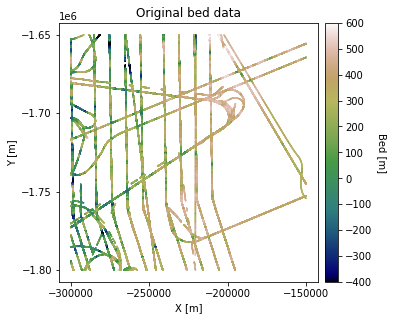

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot original data
splot2D(df=df_bed, title='Original bed data')

## Grid and transform data. Get variogram parameters

See variogram tutorials for details

In [3]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000                                               # maximum range distance
n_lags = 70                                                  # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Simple kriging with anisotropy

Here we will implement simple kriging with anisotropy by adding 15 km to the the major range (a_maj). We chose an exaggerated range anisotropy for visualization purposes. However, the major and minor ranges would normally be determined by examining the variogram at different orientations.

In [4]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0] + 15000
minor_range = V1.parameters[0]
sill = V1.parameters[1] 
vario = [azimuth, nugget, major_range, minor_range, sill]

k = 100                     # number of neighboring data points used to estimate a given point 
rad = 50000                 # 50 km search radius

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 

100%|████████████████████████████████████| 22500/22500 [02:00<00:00, 186.58it/s]


In [5]:
# reverse normal score transformation
est_SK = est_SK.reshape(-1,1)
spred_trans = nst_trans.inverse_transform(est_SK)

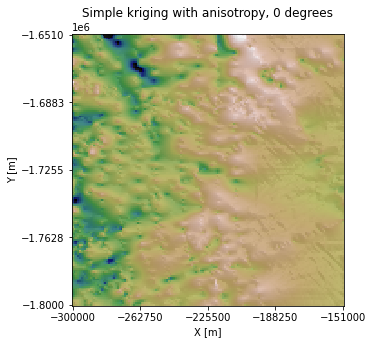

In [6]:
# make hillshade for visualizing
mplot1(Pred_grid_xy, spred_trans, rows, cols, title='Simple kriging with anisotropy, 0 degrees', hillshade=True)

In the above example, we used an Azimuth of 0, so the topography is stretched along the horizontal axis. Let's try changing the Azimuth to 60 degrees:

In [7]:
azimuth = 60
vario2 = [azimuth, nugget, major_range, minor_range, sill]

est_SK_60, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario2, rad) 

# reverse normal score transformation
est_SK_60 = est_SK_60.reshape(-1,1)
spred_trans = nst_trans.inverse_transform(est_SK_60)

100%|████████████████████████████████████| 22500/22500 [02:00<00:00, 186.14it/s]


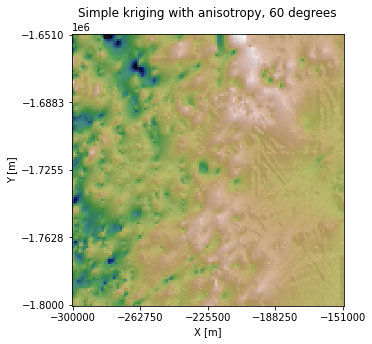

In [8]:
mplot1(Pred_grid_xy, spred_trans, rows, cols, title='Simple kriging with anisotropy, 60 degrees', hillshade=True)

## SGS with anisotropy

The same approach can be used to implement SGS with anisotropy:

In [9]:
# horizontal orientation
sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)
sim = sim.reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim)

# 60 degree orientation
sim60 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario2, rad)
sim60 = sim60.reshape(-1,1)
sim60_trans = nst_trans.inverse_transform(sim60)

100%|████████████████████████████████████| 22500/22500 [03:16<00:00, 114.27it/s]


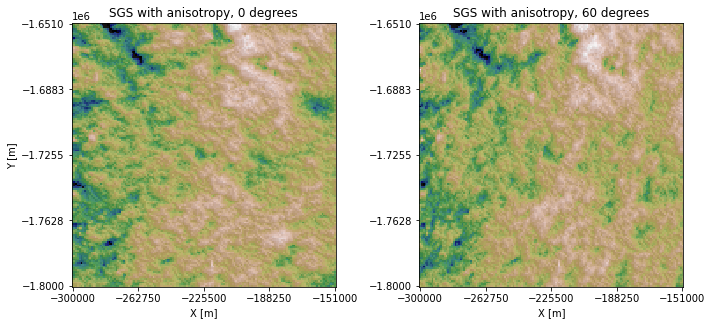

In [10]:
mplot2_hillshade(Pred_grid_xy, sim_trans, sim60_trans, rows, cols, 'SGS with anisotropy, 0 degrees',
                 'SGS with anisotropy, 60 degrees')